# Exploratory Data Analysis and Model Selection for E-Scooter Rental

***
### Table of Content

1. Introduction
        1.1 Summary
        1.2 Setup
        1.3 Load Data

2. Prepare Data for Exploration
        2.1 Check for Missing Data
        2.2 Basic Data Cleaning
        2.3 Feature Engineering

3. Exploratory Data Analysis
        3.1 Statistical Summary
        3.2 Univariate Plots
        3.3 Multivariate Plots
        3.4 Correlation Matrix
        3.5 Addressing Skews/Outliers/Zeros
            3.5.1 Addressing Skew in Total Users
            3.5.2 Addressing Outliers in Feel-like-Temperature
            3.5.3 Addressing Zeros in Relative Humidity
            3.5.4 Addressing Zeros in Windspeed
            3.5.5 Multivariate Plots
            3.5.6 Correlation Matrix

4. Modelling
        4.1 Data Preparation
        4.2 Model Selection
        4.3 Hyperparameter Optimisation
        4.4 Verify Effect of Skew on Total Users
        4.5 Verify Effect of Addressing Zeros in Relative Humidity and Windspeed
***

# 1. Introduction

## 1.1 Summary
The given dataset provides hourly values for the number of active users for an e-scooter rental service in a city. The features include the date and various weather parameters.

The purpose of this notebook is to conduct an Exploratory Data Analysis (EDA) on the abovementioned dataset. Subsequently, the ultimate task is to predict the total number of active users (guest-users and registered-users) in order to help in demand forecasting. 

### Attributes
- date: Date in YYYY-MM-DD.
- hr: Hour (0 to 23).
- weather: Description of the weather conditions for that hour.
- temperature: Average temperature for that hour (Fahrenheit).
- feels-like-temperature: Average feeling temperature for that hour (Fahrenheit).
- relative-humidity: Average relative humidity for that hour. Measure of the amount of water in the air (%).
- windspeed: Average speed of wind for that hour.
- psi: Pollutant standard index. Measure of pollutants present in the air. (0 to 400).
- guest-users: Number of guest users using the rental e-scooters in that hour.
- registered-users: Number of registered users using the rental e-scooters in that hour.
- Target: Total number of users (guest-users and registered-users).

## 1.2 Setup

In [1]:
import os

#data handling
import numpy as np
import pandas as pd
#import calendar
#from datetime import datetime

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

## 1.3 Load Dataset

In [2]:
filepath = os.getcwd()
scooter = pd.read_csv(filepath+"/scooter_rental_data.csv")
scooter.head()

date  hr weather  temperature  feels-like-temperature  \
0  2011-01-01   0   clear         66.7                    95.0   
1  2011-01-01   1   clear         65.0                    93.2   
2  2011-01-01   2   clear         65.0                    93.2   
3  2011-01-01   3   clear         66.7                    95.0   
4  2011-01-01   4   clear         66.7                    95.0   

   relative-humidity  windspeed  psi  guest-users  registered-users  
0               81.0        0.0    3           21               164  
1               80.0        0.0   35           54               417  
2               80.0        0.0   38           35               356  
3               75.0        0.0   35           19               129  
4               75.0        0.0   11           -2                10

In [3]:
scooter.shape

(17958, 10)

The given dataset contains 17958 rows of data with 8 features and corresponding number of guest and registered users. 

In [4]:
scooter.dtypes

date                       object
hr                          int64
weather                    object
temperature               float64
feels-like-temperature    float64
relative-humidity         float64
windspeed                 float64
psi                         int64
guest-users                 int64
registered-users            int64
dtype: object

- Categorical Features: weather
- Continuous Numerical Features: temperature, feels-like-temperature, relative-humidity, windspeed, psi, guest-users, registered-users
- Time-series Based Numerical Features: date, hr

***
# 2. Prepare Data for Exploration
## 2.1 Check for missing data

In [5]:
scooter.isnull().sum()

date                      0
hr                        0
weather                   0
temperature               0
feels-like-temperature    0
relative-humidity         0
windspeed                 0
psi                       0
guest-users               0
registered-users          0
dtype: int64

The given dataset does not have any missing values. 

## 2.2 Basic Data Cleaning

In [6]:
scooter.weather.value_counts()

clear              11186
cloudy              4492
light snow/rain     1429
lear                 323
CLEAR                288
loudy                111
CLOUDY                95
LIGHT SNOW/RAIN       31
heavy snow/rain        3
Name: weather, dtype: int64

Weather feature requires cleaning as there are repeated categories due to spelling errors or differing letter case. This could be a result of allowing the input to this feature to be typed in during data collection. The data collection can be improved by using dropdown to maintain consistency in the responses for this feature. 

In [7]:
scooter['weather'] = scooter['weather'].replace(['clear', 'lear', 'CLEAR'], '1')
scooter['weather'] = scooter['weather'].replace(['cloudy', 'loudy', 'CLOUDY'], '2')
scooter['weather'] = scooter['weather'].replace(['LIGHT SNOW/RAIN', 'light snow/rain'], '3')
scooter['weather'] = scooter['weather'].replace('heavy snow/rain', '4')
scooter['weather'] = scooter['weather'].astype(int)
scooter.weather.value_counts()

1    11797
2     4698
3     1460
4        3
Name: weather, dtype: int64

## 2.3 Feature Engineering
For the date data, we can extract out certain useful information which might affect the number of users. For example, the month and day of the week are expected to have an impact on the number of users renting the e-scooters. The year could be used to see if the trend is similar across the years. Lastly, the total number of users is also created by combining the number of guest and registered users. 

In [8]:
scooter['date'] = pd.to_datetime(scooter['date'])
scooter['year'] = scooter['date'].dt.year
scooter['month'] = scooter['date'].dt.month
scooter['day'] = scooter['date'].dt.dayofweek
scooter["total_users"] = scooter["guest-users"] + scooter["registered-users"]
scooter.head(10)

date  hr  weather  temperature  feels-like-temperature  \
0 2011-01-01   0        1         66.7                    95.0   
1 2011-01-01   1        1         65.0                    93.2   
2 2011-01-01   2        1         65.0                    93.2   
3 2011-01-01   3        1         66.7                    95.0   
4 2011-01-01   4        1         66.7                    95.0   
5 2011-01-01   5        2         66.7                    91.4   
6 2011-01-01   6        1         65.0                    93.2   
7 2011-01-01   7        1         63.3                    91.4   
8 2011-01-01   8        1         66.7                    95.0   
9 2011-01-01   9        1         73.5                   102.2   

   relative-humidity  windspeed  psi  guest-users  registered-users  year  \
0               81.0        0.0    3           21               164  2011   
1               80.0        0.0   35           54               417  2011   
2               80.0        0.0   38           35               356  2011   
3               75.0        0.0   35           19               129  2011   
4               75.0        0.0   11           -2                10  2011   
5               75.0        6.0   12            2                10  2011   
6               80.0        0.0   19           15                 2  2011   
7               86.0        0.0   33            5                27  2011   
8               75.0        0.0   45            8                96  2011   
9               76.0        0.0   33           57                73  2011   

   month  day  total_users  
0      1    5          185  
1      1    5          471  
2      1    5          391  
3      1    5          148  
4      1    5            8  
5      1    5           12  
6      1    5           17  
7      1    5           32  
8      1    5          104  
9      1    5          130

***
# 3. Exploratory Data Analysis
## 3.1 Statistical Summary

In [9]:
scooter.describe()

hr       weather   temperature  feels-like-temperature  \
count  17958.000000  17958.000000  17958.000000            17958.000000   
mean      11.533578      1.424713     88.457512              117.332008   
std        6.915319      0.638716     16.285017               20.416251   
min        0.000000      1.000000     48.100000               60.800000   
25%        6.000000      1.000000     75.200000              100.400000   
50%       12.000000      1.000000     88.700000              118.400000   
75%       18.000000      2.000000    102.200000              134.600000   
max       23.000000      4.000000    131.000000              179.600000   

       relative-humidity     windspeed           psi   guest-users  \
count       17958.000000  17958.000000  17958.000000  17958.000000   
mean           62.758993     12.733155     24.557300    249.740394   
std            19.266532      8.213750     14.451091    344.815252   
min             0.000000      0.000000      0.000000     -2.000000   
25%            48.000000      7.000000     12.000000     27.000000   
50%            63.000000     13.000000     24.000000    117.000000   
75%            78.000000     17.000000     37.000000    338.000000   
max           100.000000     57.000000     49.000000   2567.000000   

       registered-users          year         month           day  \
count      17958.000000  17958.000000  17958.000000  17958.000000   
mean        1998.910346   2011.502450      6.539370      3.013142   
std         1966.561546      0.500008      3.438184      2.002378   
min           -5.000000   2011.000000      1.000000      0.000000   
25%          441.000000   2011.000000      4.000000      1.000000   
50%         1504.000000   2012.000000      7.000000      3.000000   
75%         2860.000000   2012.000000     10.000000      5.000000   
max        11519.000000   2012.000000     12.000000      6.000000   

        total_users  
count  17958.000000  
mean    2248.650741  
std     2161.485842  
min        1.000000  
25%      483.000000  
50%     1699.000000  
75%     3308.750000  
max    12154.000000

Looking at the overview of the numerical features, a number of observations can be made:
1. hr feature range is within 0-23 as expected
2. relative-humidity does not go beyond 100 as expected, but there are zero values
3. psi range is within 0-400 as expected
4. range for month and day are as expected.
5. dataset contains data collected over 2 years (2011-2012)

## 3.2 Univariate Plots

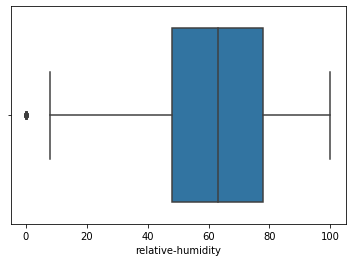

In [10]:
sns.boxplot(scooter['relative-humidity'])

As mentioned above, there are zero values for relative humidity which seem to be outliers. 

## 3.3 Multivariate Plots

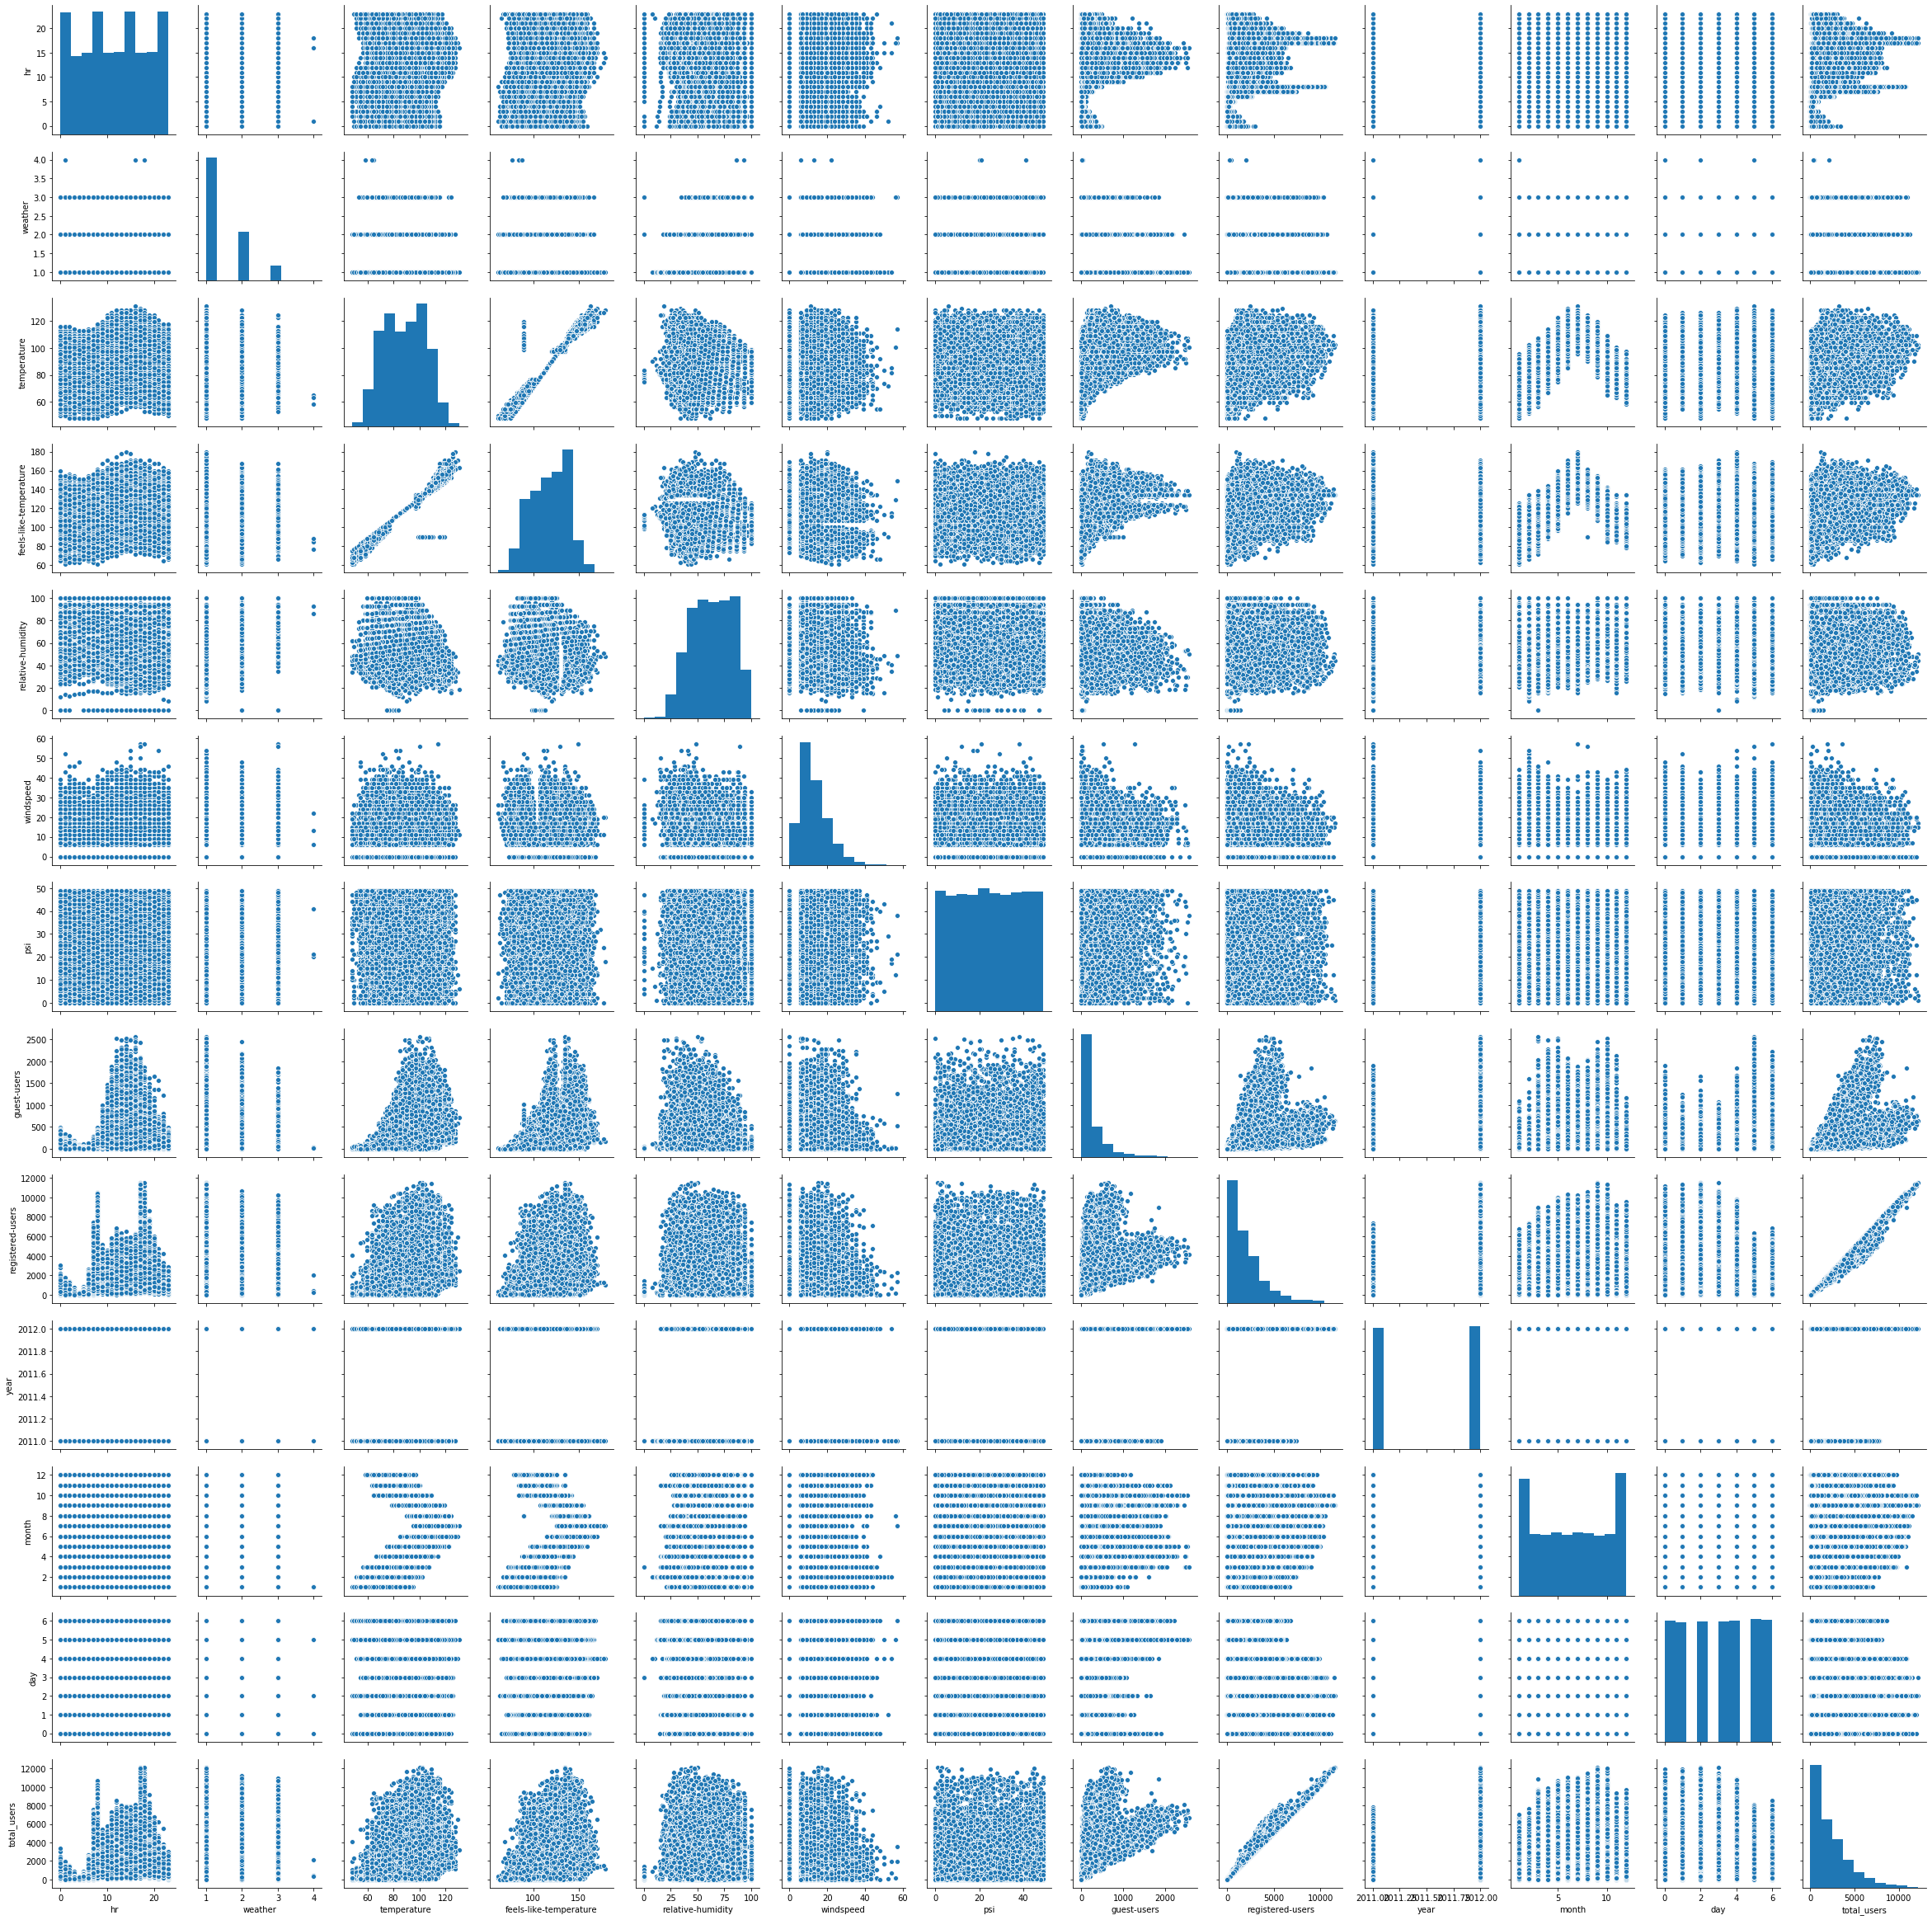

In [11]:
sns.pairplot(scooter)

Observations from above scatter matrix:
- Temperature and feels-like-temperature have a linear relationship with a group of anomalous values where feels-like-temperature is lower than temperature
- Temperature and feels-like-temperature are affected by hr and month
- Relative humidity has a number of zero values which appear anomalous
- Windspeed has a significant number of zero values which appear anomalous
- Number of total users is affected by hr, weather, temperature, feels-like-temperature, relative humidity, windspeed, month and day
- There are more total users in 2012 than 2011
- Number of total users is highly skewed. Will probably need to transform the dependent variable to be closer to normal distribution to facilitate better prediction 


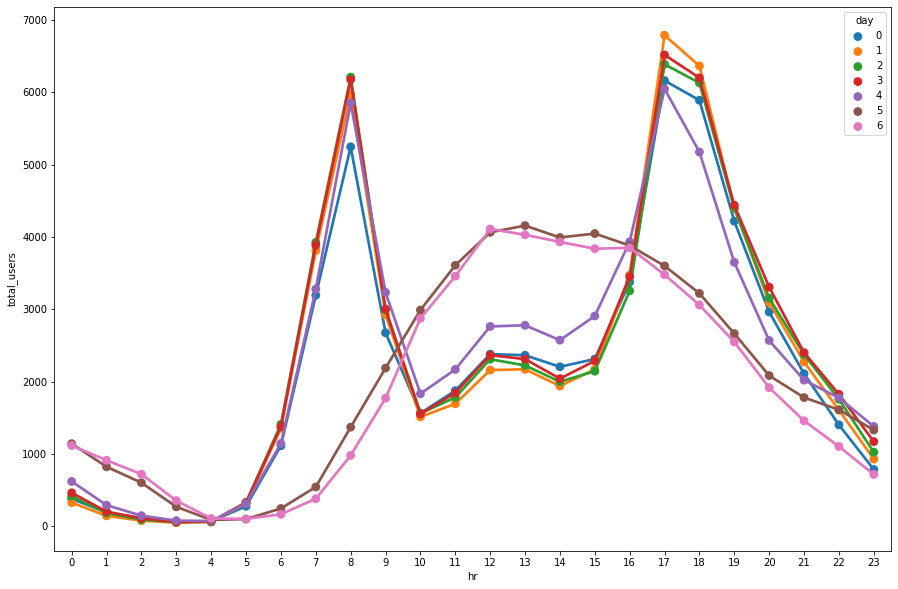

In [12]:
hour_day = pd.DataFrame(scooter.groupby(['hr','day'],sort=True)['total_users'].mean()).reset_index()
plt.figure(figsize=(15,10))
sns.pointplot(x=hour_day['hr'], y=hour_day['total_users'], hue=hour_day['day'], data=hour_day)

Based on the above plot, it can be seen that the trend for weekdays (days 0 to 4) is quite consistent and the same can be said for the trend for weekends (days 5 to 6). For weekday, there are 2 significant peaks in total users which coincide with before and after office hours. This is expected as users would be using the e-scooters to travel to and from work. For weekends, there are generally more users over the afternoon. 

## 3.4 Correlation Matrix

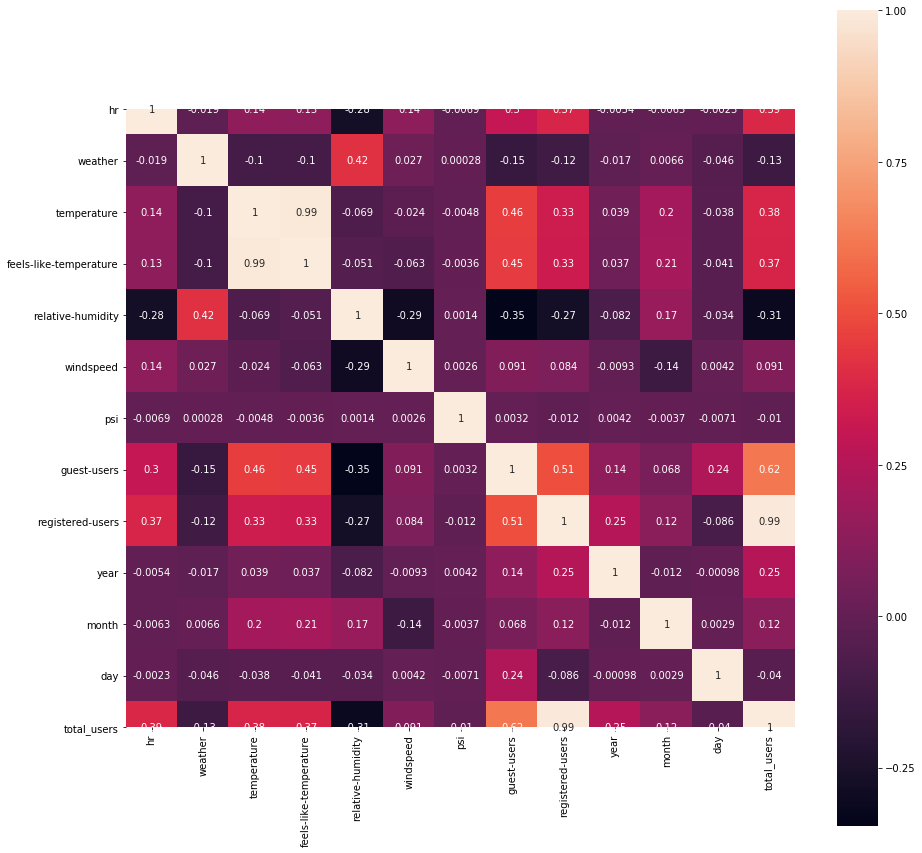

In [13]:
plt.figure(figsize=(15,15))
sns.heatmap(scooter.corr(), square=True, annot=True)

Observations from above correlation matrix:
- Temperature and feels-like-temperature are highly related as mentioned previously
- Hr, temperature, feels-like-temperature affects total number of users
- Weather affects the total number of users. This is expected as the number of users would decrease when there is rain/snow.
- Weather affects relative humidity. This is expected as relative humidity increases with rain/snow.
- Relative humidity is inversely related to the total number of users. This is expected as when relative humidity increases, the number of users renting e-scooter should decrease. 
- Month affects temperature and feels-like-temperature. This is expected as temperatures would be seasonal.  

##  3.5 Addressing Skew/Outliers/Zeros

### 3.5.1 Addressing Skew in Total Users

As mentioned above, there is a significant skew in the total users. To address this, the values can be transformed to be closer to normal distribution as shown below. 

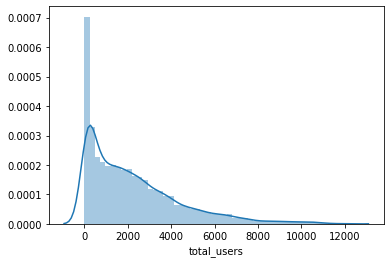

In [14]:
sns.distplot(scooter['total_users'])

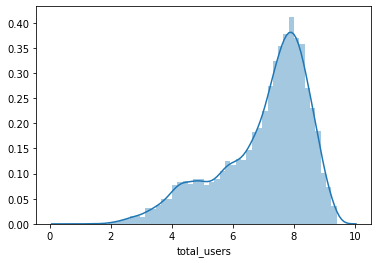

In [15]:
scooter['total_users'] = np.log1p(scooter['total_users'])
sns.distplot(scooter['total_users'])

### 3.5.2 Addressing Outliers in Feels-Like-Temperature

As discovered in the multivariate plots above, there are outliers in the feels-like-temperature data where they are lower than temperature. 

In [16]:
scooter.dtypes

date                      datetime64[ns]
hr                                 int64
weather                            int32
temperature                      float64
feels-like-temperature           float64
relative-humidity                float64
windspeed                        float64
psi                                int64
guest-users                        int64
registered-users                   int64
year                               int64
month                              int64
day                                int64
total_users                      float64
dtype: object

In [17]:
category = ['hr', 'weather', 'month', 'day']
for col in category:
    scooter[col] = scooter[col].astype("category")
scooter['psi'] = scooter['psi'].astype(float)
scooter.dtypes

date                      datetime64[ns]
hr                              category
weather                         category
temperature                      float64
feels-like-temperature           float64
relative-humidity                float64
windspeed                        float64
psi                              float64
guest-users                        int64
registered-users                   int64
year                               int64
month                           category
day                             category
total_users                      float64
dtype: object

In [18]:
scooter.loc[scooter['feels-like-temperature'].astype(int)<scooter['temperature'].astype(int)]

date  hr weather  temperature  feels-like-temperature  \
14131 2012-08-17   0       1        103.9                    89.6   
14132 2012-08-17   1       1        102.2                    89.6   
14133 2012-08-17   2       1        102.2                    89.6   
14134 2012-08-17   3       1        100.5                    89.6   
14135 2012-08-17   4       1        100.5                    89.6   
14136 2012-08-17   5       1        100.5                    89.6   
14137 2012-08-17   6       1         98.9                    89.6   
14138 2012-08-17   7       1        100.5                    89.6   
14139 2012-08-17   8       1        103.9                    89.6   
14140 2012-08-17   9       1        105.6                    89.6   
14141 2012-08-17  10       1        109.0                    89.6   
14142 2012-08-17  11       1        110.7                    89.6   
14143 2012-08-17  12       1        115.8                    89.6   
14144 2012-08-17  13       1        117.5                    89.6   
14145 2012-08-17  14       1        119.2                    89.6   
14146 2012-08-17  15       1        119.2                    89.6   
14147 2012-08-17  16       2        117.5                    89.6   
14148 2012-08-17  17       1        115.8                    89.6   
14149 2012-08-17  18       2        115.8                    89.6   
14150 2012-08-17  19       2        109.0                    89.6   
14151 2012-08-17  20       2        107.3                    89.6   
14152 2012-08-17  21       2        103.9                    89.6   
14153 2012-08-17  22       3        102.2                    89.6   
14154 2012-08-17  23       3        100.5                    89.6   
17642 2012-08-17   2       1        102.2                    89.6   
17672 2012-08-17  17       1        115.8                    89.6   

       relative-humidity  windspeed   psi  guest-users  registered-users  \
14131               57.0       11.0  23.0          146               874   
14132               65.0        7.0  24.0          112               489   
14133               61.0        9.0   2.0           28               191   
14134               65.0        7.0  21.0            2                74   
14135               73.0       11.0  40.0            0               115   
14136               73.0        7.0  45.0           15               440   
14137               78.0        9.0  31.0           40              1962   
14138               73.0        7.0  30.0           79              4787   
14139               65.0        9.0   1.0          301              8126   
14140               58.0        7.0  13.0          404              4161   
14141               55.0       11.0  24.0          572              1938   
14142               52.0       19.0  16.0          685              2667   
14143               41.0       15.0  27.0          768              3316   
14144               36.0       26.0  37.0          721              3302   
14145               34.0       28.0  19.0          898              2605   
14146               30.0       31.0  35.0          888              3326   
14147               32.0       30.0  29.0          810              4841   
14148               36.0       22.0  15.0         1007              8408   
14149               38.0       17.0  38.0          758              7288   
14150               55.0       26.0  31.0          616              5237   
14151               58.0       15.0  45.0          678              3405   
14152               69.0       20.0  16.0          398              2574   
14153               83.0       13.0  30.0          300              2205   
14154               83.0       15.0  25.0          146              1300   
17642               61.0        9.0   2.0           28               191   
17672               36.0       22.0  15.0         1007              8408   

       year month day  total_users  
14131  2012     8   4     6.928538  
14132  2012     8   4

Coincidentally, the outliers were collected on the same date of 2012-08-17. Even though the temperature changes, there is no change in feels-like-temperature. This could be due to incorrect filling during data collection. However, since temperature and feels-like-temperature has strong correlation as shown in the multivariate plot and correlation matrix, feels-like-temperature can be dropped when predicting the number of users to avoid multicollinearity manifesting in the data.

### 3.5.3 Addressing Zero Values in Relative Humidity

As discovered in the univariate and multivariate plots above, there are zero values in Relative Humidity which appear anomalous. Random Forest Regressor can be used to address the zero values in Relative Humidity. 

In [19]:
hum0 = scooter.copy()
humNot0 = scooter.copy()
hum0 = hum0.loc[hum0['relative-humidity']==0]
humNot0 = humNot0.loc[humNot0['relative-humidity']!=0]
predictors = ['hr', 'weather', 'temperature', 'month', 'day']
rf_hum = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf_hum.fit(humNot0[predictors], humNot0['relative-humidity'])
hum0['relative-humidity'] = rf_hum.predict(X=hum0[predictors])
scooter_h = humNot0.append(hum0)
scooter_h.sort_index(inplace=True)

### 3.5.4 Addressing Zero Values in Windspeed

As discovered in the multivariate plots above, there is a significant number of zero values in windspeed, 2264 to be exact, which appear anomalous. Random Forest Regressor can be used to address the zero values in Relative Humidity. 

In [20]:
scooter['windspeed'].isin([0]).sum()

2264

In [21]:
wind0 = scooter_h.copy()
windNot0 = scooter_h.copy()
wind0 = wind0.loc[wind0['windspeed']==0]
windNot0 = windNot0.loc[windNot0['windspeed']!=0]
predictors = ['hr', 'weather', 'relative-humidity', 'temperature', 'month', 'day']
rf_wind = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf_wind.fit(windNot0[predictors], windNot0['windspeed'])
wind0['windspeed'] = rf_wind.predict(X=wind0[predictors])
scooter_h_w = windNot0.append(wind0)
scooter_h_w.sort_index(inplace=True)

### 3.5.5 Multivariate Plot

The plots below confirms that the skew in total users and zero values in relative humidity and windspeed have been addressed. 

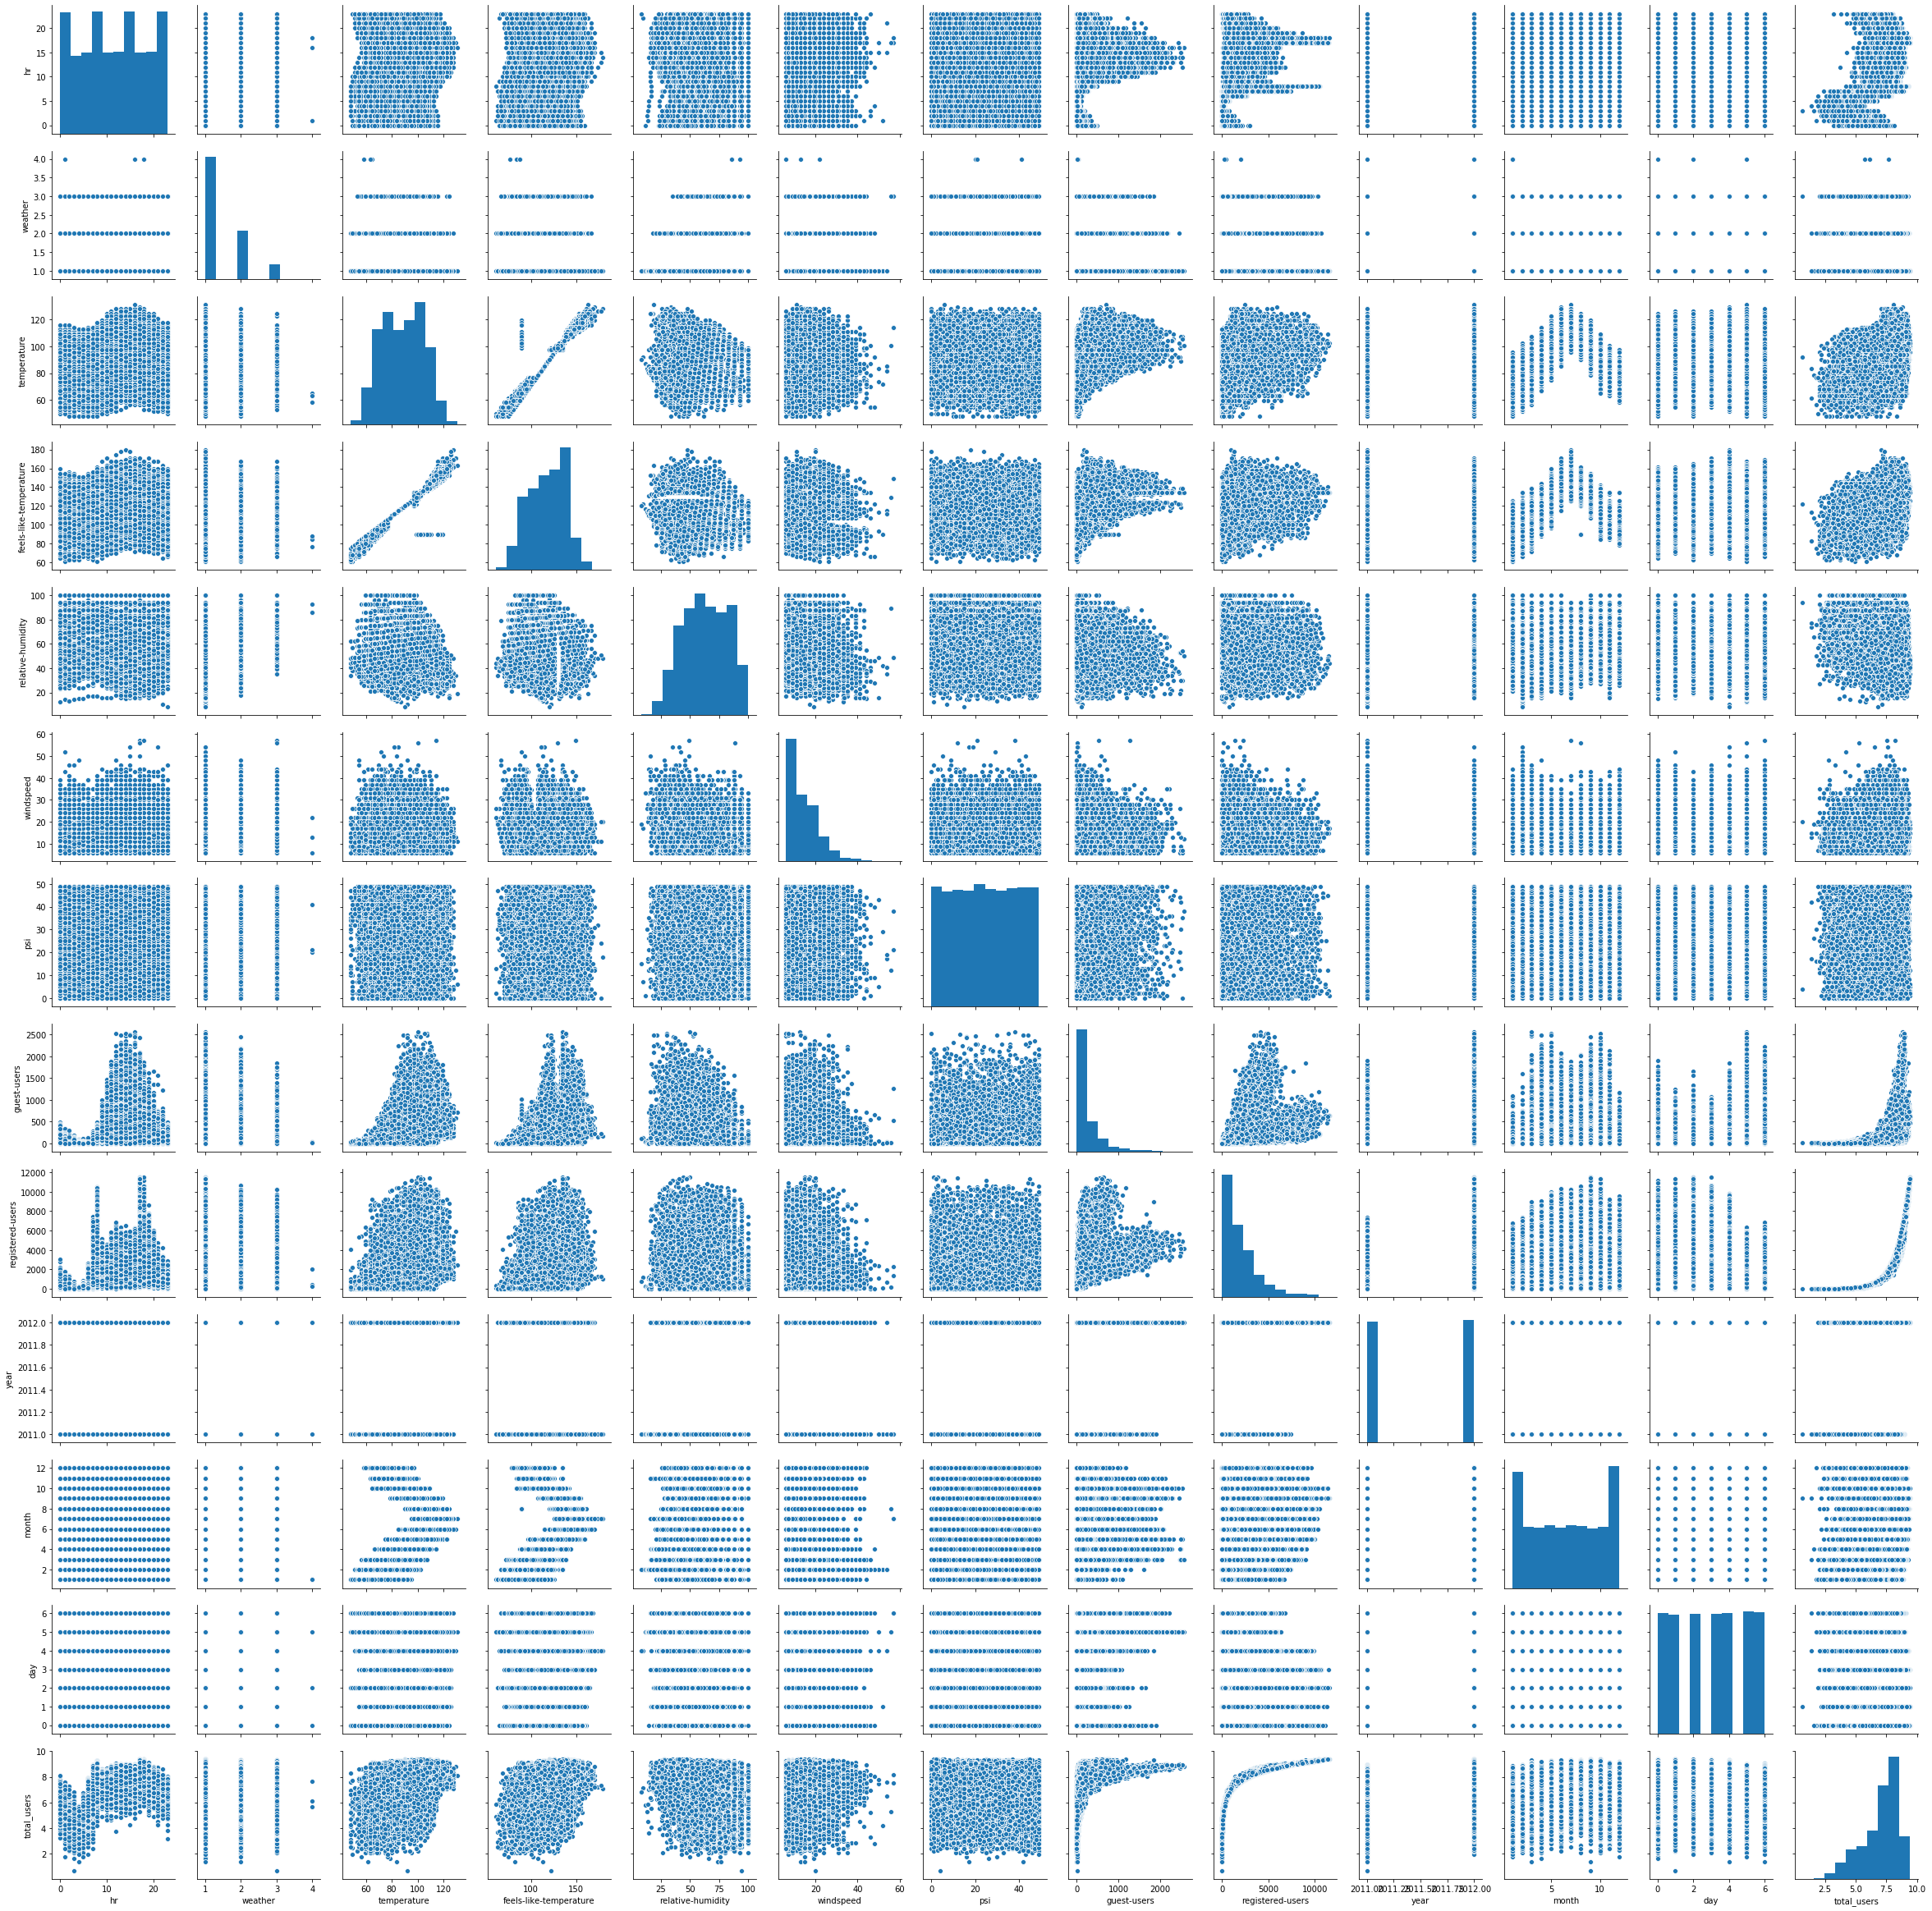

In [22]:
sns.pairplot(scooter_h_w)

### 3.5.6 Correlation Matrix

The matrix below confirms that there is no significant impact to the correlation matrix after addressing the skew in total users and zero values in relative humidity and windspeed. 

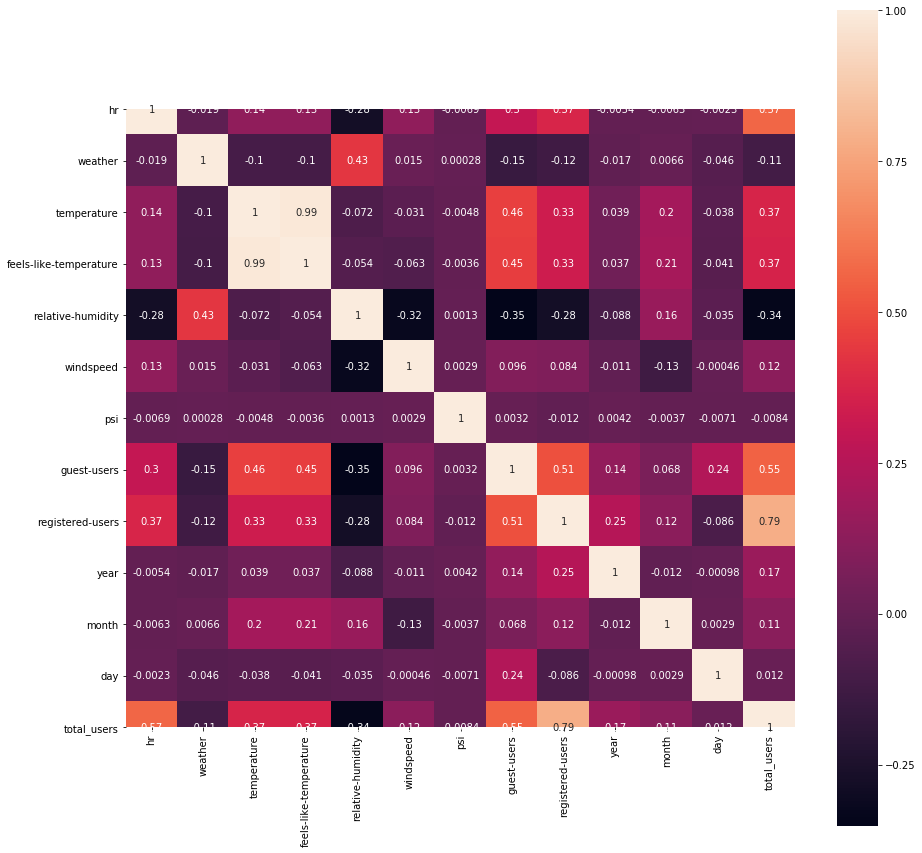

In [23]:
category = ['hr', 'weather', 'month', 'day']
for col in category:
    scooter_h_w[col] = scooter_h_w[col].astype("int")
plt.figure(figsize=(15,15))
sns.heatmap(scooter_h_w.corr(), square=True, annot=True)

***
# 4. Modelling

# 4.1 Data Preparation

To model for machine learning, we would drop the following features from the dataset:
- date: This feature is dropped as we have performed feature engineering to extract the month and day of week which have more useful relationship with the total users. Leaving this in the dataset would also affect the ability for the algorithms to handle datapoints which happen beyond 2012. 
- feels-like-temperature: As mentioned above, this feature should be dropped as there are anomalous values which would affect the training process and this feature might introduce multicollinearity due to the strong correlation with temperature feature.
- guest-users and registered-users: Dropping them as they have been combined into total_users and to prevent leakage of targets into the model when training. 
- year: Leaving this in the dataset would affect the ability for the algorithms to handle datapoints which happen beyond 2012.

In [24]:
X = scooter.drop(['date', 'feels-like-temperature', 'guest-users', 'registered-users', 'year', 'total_users'], axis=1)
X.head()

hr weather  temperature  relative-humidity  windspeed   psi month day
0  0       1         66.7               81.0        0.0   3.0     1   5
1  1       1         65.0               80.0        0.0  35.0     1   5
2  2       1         65.0               80.0        0.0  38.0     1   5
3  3       1         66.7               75.0        0.0  35.0     1   5
4  4       1         66.7               75.0        0.0  11.0     1   5

In [25]:
y = scooter['total_users']
y.head()

0    5.225747
1    6.156979
2    5.971262
3    5.003946
4    2.197225
Name: total_users, dtype: float64

Dataset is split into training (75%) and validation (25%) sets. 

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

## 4.2 Model Selection

Perform prediction using various algorithms and evaluate their performance to select the most appropriate model. 

In [27]:
models=[KNeighborsRegressor(), LinearRegression(), RandomForestRegressor(n_jobs=-1), SVR(), GradientBoostingRegressor()]
model_names=['KNeighborsRegressor', 'LinearRegression', 'RandomForestRegressor', 'SVR', 'GradientBoostingRegressor']
r2 = []
for model in range(len(models)):
    ml = models[model]
    ml.fit(X_train, y_train)
    score = ml.score(X_val, y_val)
    r2.append(score)
results={'Model': model_names, 'Score': r2}
results_df = pd.DataFrame(results)
results_df

C:\Users\Enqing\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Enqing\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Model     Score
0        KNeighborsRegressor  0.572996
1           LinearRegression  0.450568
2      RandomForestRegressor  0.900990
3                        SVR  0.102372
4  GradientBoostingRegressor  0.890029

Based on accuracy, RandomForestRegressor has the best performance (about 0.90) and will be used for further prediction. The accuracy of other models would probably improve with scaling of the features. 

## 4.3 Hyperparameters Optimisation

GridSearchCV is used to find the best hyperparameters for RandomForestRegressor. 

In [28]:
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_features': ['auto', 'log2', 'sqrt'],
    'n_jobs': [-1]
}
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid.fit(X_train, y_train)
grid.best_params_

{'max_features': 'auto', 'n_estimators': 1000, 'n_jobs': -1}

In [29]:
print("Best cross-validation score: {:.3f}".format(grid.best_score_))

Best cross-validation score: 0.905


In [30]:
print("Validate set accuracy: {:.3f}".format(grid.score(X_val, y_val)))

Validate set accuracy: 0.911


Hyperparameters optimisation yielded about accuracy of about 0.905 for cross-validation and about 0.911 on validation set. 

## 4.4 Verify Effect of Skew on Total Users Data

With the selected model, let's see if using the skewed total users data would affect the performance. 

In [31]:
y1 = np.expm1(y)
y1 = y1.astype("int")
y1.head()

0    185
1    470
2    390
3    148
4      8
Name: total_users, dtype: int32

In [32]:
X1_train, X1_val, y1_train, y1_val = train_test_split(X, y1, random_state=0)
rf = RandomForestRegressor(n_estimators=1000, max_features='auto', n_jobs=-1)
rf.fit(X1_train, y1_train)
rf.score(X1_val, y1_val)

0.8421502798011052

As seen above, transforming the target did help to improve the accuracy of the model. 

## 4.5 Verify Effect of Addressing Zeroes in Relative Humidity and Windspeed

With the selected model, let's see if addressing the relative humidity and windspeed in the data would help to improve the performance. 

In [33]:
X2 = scooter_h_w.drop(['date', 'feels-like-temperature', 'guest-users', 'registered-users', 'year', 'total_users'], axis=1)
for col in category:
    X2[col] = X2[col].astype("category")
X2.dtypes

hr                   category
weather              category
temperature           float64
relative-humidity     float64
windspeed             float64
psi                   float64
month                category
day                  category
dtype: object

In [34]:
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y, random_state=0)
rf = RandomForestRegressor(n_estimators=1000, max_features='auto', n_jobs=-1)
rf.fit(X2_train, y2_train)
rf.score(X2_val, y2_val)

0.9113514865949505

In [35]:
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_features': ['auto', 'log2', 'sqrt'],
    'n_jobs': [-1]
}
grid2 = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid2.fit(X2_train, y2_train)
grid2.best_params_

{'max_features': 'auto', 'n_estimators': 1000, 'n_jobs': -1}

In [36]:
print("Best cross-validation score: {:.3f}".format(grid2.best_score_))

Best cross-validation score: 0.905


In [37]:
print("Validate set accuracy: {:.3f}".format(grid2.score(X2_val, y2_val)))

Validate set accuracy: 0.911


As seen above, the impact of the zero values in relative humidity and windspeed did not have a significant impact on the accuracy of the model.